In [57]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

# Import the wurttemberg-with-names.shp file and convert the ID colum to integer.
shape = gpd.read_file('wurttemberg-with-names.shp')
shape['ID'] = shape['ID'].astype(int)

# Import the Notgeld data, and convert the Ort column to name so we can merge it.
notgeld = pd.read_excel('raw-data/Notgeld_V2.xlsx')
notgeld = notgeld.rename(columns={'Ort': 'name'})

# Replace the faulty names in the notgeld dataframe.
notgeld['name'] = notgeld['name'].str.replace('Cannstadt', 'Cannstatt')
notgeld['name'] = notgeld['name'].str.replace('Heidenhein', 'Heidenheim')
notgeld['name'] = notgeld['name'].str.replace('Biberach/Riss', 'Biberach an der Riß')
notgeld['name'] = notgeld['name'].str.replace('Freudenstadt/Baiersbonn', 'Freudenstadt')
notgeld['name'] = notgeld['name'].str.replace('Oberndorf, Rottweil, …', 'Rottweil') # Check again.

# Merge the shape and notgeld dataframes on right, but keep all rows from the notgeld dataframe.
merged = shape.merge(notgeld, on='name', how='inner')

# Keep only the rows with the Hochinflation 1923, we are only interested in that period.
merged = merged[merged['Periode'] == 'Hochinflation 1923']

# Maintanance on the Wert column so we can convert it to numeric.
merged['Wert'] = merged['Wert'].str.replace(' ', '')
# Replace the following strings with the corresponding values.
merged['Wert'] = merged['Wert'].str.replace('Bio', '000000000000')
merged['Wert'] = merged['Wert'].str.replace('Mio', '000000')
merged['Wert'] = merged['Wert'].str.replace('Mrd', '000000000')
merged['Wert'] = merged['Wert'].str.replace('T', '000000000000000')
merged['Wert'] = pd.to_numeric(merged['Wert'])

# Convert the Wert column to logaritmic, so the mapping is more accurate.
merged['Wert'] = np.log10(merged['Wert'])

In [58]:
# Count how many times an ID appears in the dataframe.
counts = merged['ID'].value_counts()
# Create a count column in the merged dataframe.
merged['count'] = merged['ID'].map(counts)

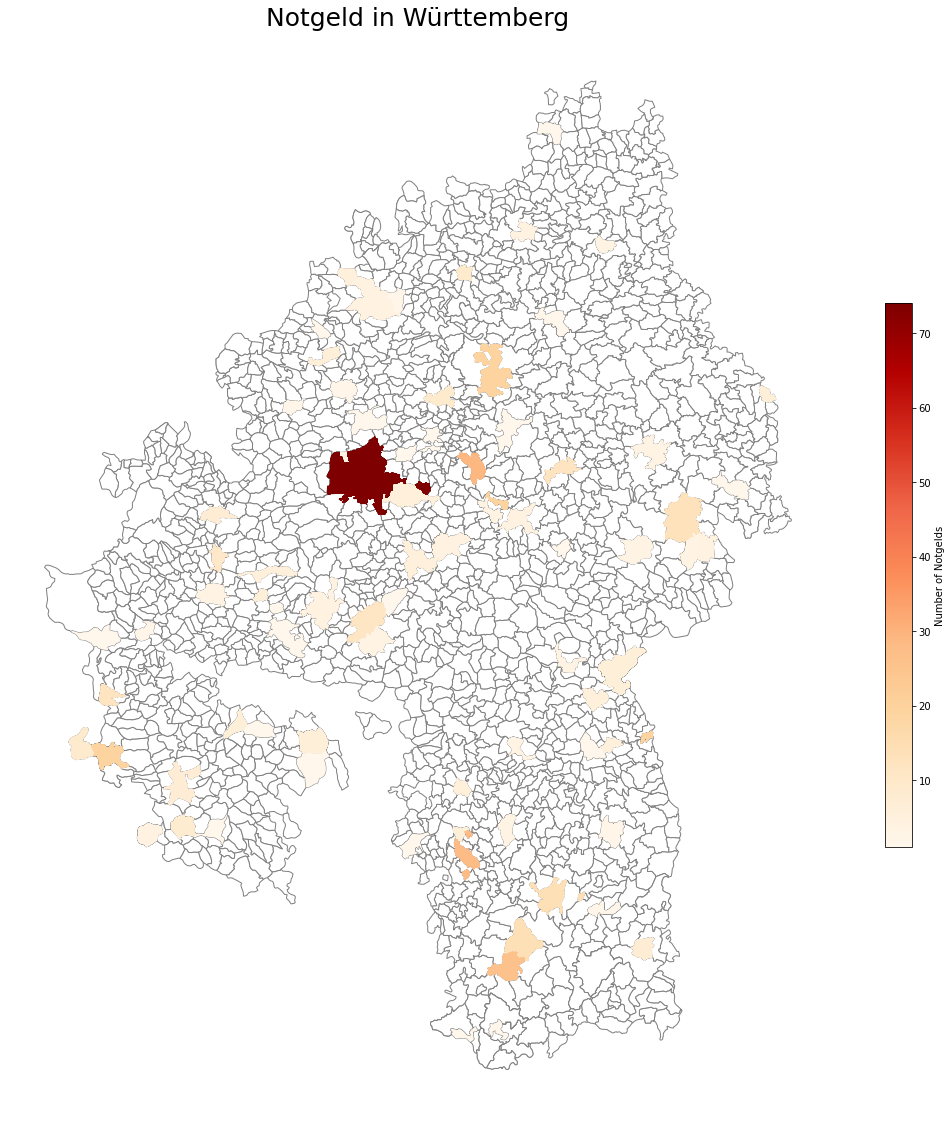

In [59]:
# Visualize the counts per ID.
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_title('Notgeld in Württemberg', fontdict={'fontsize': '25', 'fontweight' : '3'}, loc='center')
shape.plot(ax=ax, color='white', edgecolor='gray')
merged.plot(ax=ax, column='count', cmap='OrRd', legend=True, legend_kwds={'label': 'Number of Notgelds', 'shrink': 0.5})
plt.axis('off')
plt.show()

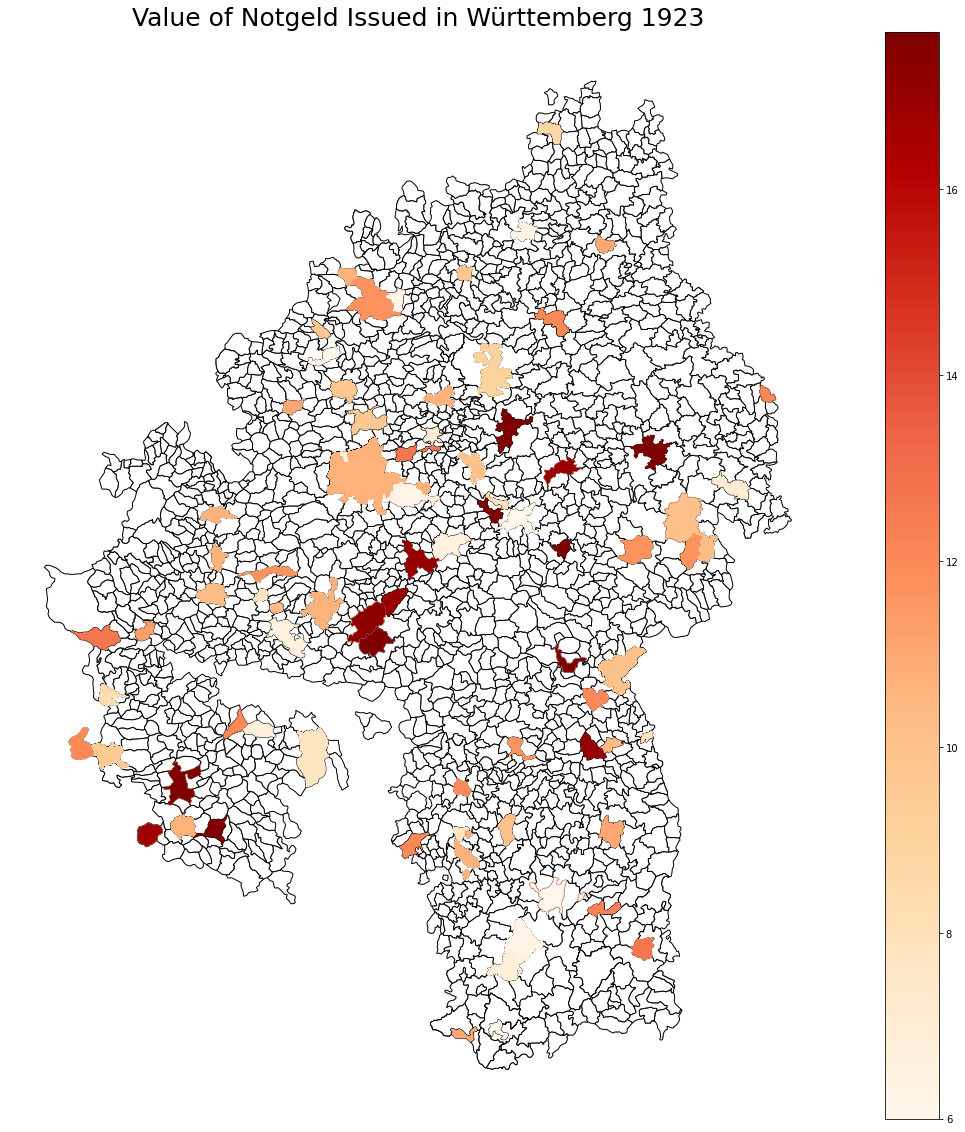

In [60]:
# Plot the map of the values of the notgeld.
fig, ax = plt.subplots(figsize=(20, 20))
ax.axis('off')
ax.set_title('Value of Notgeld Issued in Württemberg 1923', fontdict={'fontsize': '25', 'fontweight' : '3'})
shape.plot(ax=ax, color='white', edgecolor='black')
merged.plot(ax=ax, column='Wert', cmap='OrRd', legend=True)
# Save the plot to a file.
plt.savefig('figures/notgeld-value.png', dpi=300)

In [61]:
# Import the distance data which is in the form of a csv file.
distance = pd.read_csv('reichsbank-distances.csv')
# Create a new gdf from shape.
gdf = gpd.GeoDataFrame(shape)
# Drop the name column from the gdf.
gdf = gdf.drop(columns=['name'])
# Merge distance and gdf on the ID column.
gdf = gdf.merge(distance, on='ID', how='inner')

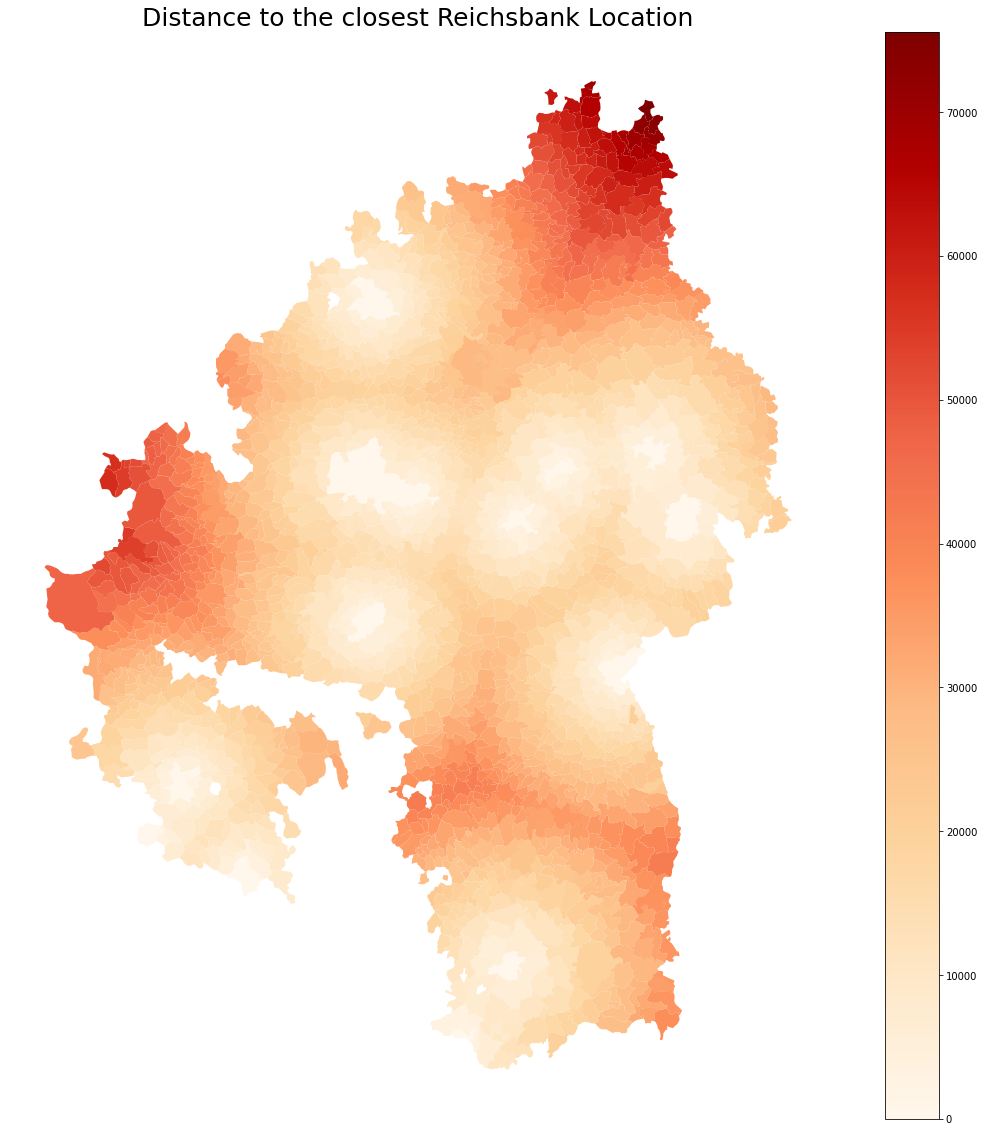

In [62]:
# Plot the map of the distances.
fig, ax = plt.subplots(figsize=(20, 20))
ax.axis('off')
ax.set_title('Distance to the closest Reichsbank Location', fontdict={'fontsize': '25', 'fontweight' : '3'})
gdf.plot(ax=ax, column='distance', cmap='OrRd', legend=True)
plt.savefig('figures/notgeld-distance-to-reichsbank.png', dpi=300)

In [67]:
# Convert counts to a dataframe with the ID and count columns.
test = pd.DataFrame(counts)
# Reset the index.
test = test.reset_index()
# Rename the columns.
test = test.rename(columns={'index': 'ID', 'ID': 'count'})
# Merge gdf and test on the ID column.
distance_count = gdf.merge(test, on='ID', how='outer')
# Fill NaN values with 0.
distance_count = distance_count.fillna(0)
# Drop duplicates by ID.
distance_count = distance_count.drop_duplicates(subset=['ID'])
# Convert count to integer.
distance_count['count'] = distance_count['count'].astype(int)

In [ ]:
# Save the distance_count dataframe to a csv file.
distance_count.to_csv('stata-analysis/wurttemberg-reichsbank-database.csv')